# Initialisation du projet

In [1]:
!pip install pandas
!pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
import random
import math 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


Ouverture du fichier sous forme url pour la reproductibilité

In [21]:
csv_url = 'https://www.data.gouv.fr/fr/datasets/r/47ac11c2-8a00-46a7-9fa8-9b802643f975'
df_festival = pd.read_csv(csv_url, sep = ';')
print(df_festival.head())

                                 nom_du_festival envergure_territoriale  \
0                                         Gamerz         Départementale   
1  Corsiclassic - festival de musique de chambre                    NaN   
2                                Racines de ciel                    NaN   
3                               Le grand bivouac         Intercommunale   
4                                Festival Acthea                    NaN   

  region_principale_de_deroulement departement_principal_de_deroulement  \
0       Provence-Alpes-Côte d'Azur                     Bouches-du-Rhône   
1                            Corse                         Corse-du-Sud   
2                            Corse                         Corse-du-Sud   
3             Auvergne-Rhône-Alpes                               Savoie   
4                        Occitanie                                 Tarn   

  commune_principale_de_deroulement  \
0                   Aix-en-Provence   
1                   

## I. Nettoyage des données
### A) La colonne année


Nettoyage de la colonne année qui contient certes des années mais aussi des dates exactes et des entrées comme "53e" (on suppose, pour "53e3 édition). Pour les entrées de la colonne année qui sont des NaN ou qui sont de formes irrégulières (comme "53e"), on utilise la colonne décennie qui nous renseigne la décennie de création du festival et on choisit au hasard une année dans cette décennie pour imputer dans la colonne année.

In [5]:
col_array = np.array(df_festival['annee_de_creation_du_festival'])

# Fonction pour générer un nombre aléatoire dans la décennie
def annee_aleatoire(decennie):
    decennie_str = str(decennie)
    annees = re.findall(r'\d{4}', decennie_str)
    if annees:
        debut_decennie = int(annees[0])
        return np.random.randint(debut_decennie, debut_decennie + 10)
    else:
        return None

# Remplacer les valeurs non valides (qui ne sont pas une année ou une date) par un nombre aléatoire dans la décennie
col = np.array([float(datetime.strptime(str(date), '%d/%m/%Y %H:%M').year) if re.match(r'\d{2}/\d{2}/\d{4} \d{2}:\d{2}$', str(date)) else float(date) if re.match(r'\d{4}$', str(date)) else annee_aleatoire(df_festival.at[i, 'decennie_de_creation_du_festival']) for i, date in enumerate(col_array)])

df_festival['annee_creation'] = col
col_None = [x for x in col if x is not None]

print(df_festival[['annee_de_creation_du_festival', 'annee_creation']])


     annee_de_creation_du_festival annee_creation
0                             2006         2006.0
1                             2016         2016.0
2                             2009         2009.0
3                             2002         2002.0
4                              NaN           None
...                            ...            ...
7277                           NaN           1999
7278                          2016         2016.0
7279                           NaN           2008
7280                           NaN           None
7281                          2018         2018.0

[7282 rows x 2 columns]


On importe une base de données au niveau communal pour avoir des informations sur la population des communes dans lesquelles se déroulent le festival et plus tard espérer trouver un lien entre l'emplacement de ces derniers et leurs caractéristiques. (Faire tourner ce bloc prend environ 2 minutes car le fichier est gros).

In [6]:
xlsx_file_path = 'base-cc-evol-struct-pop-2019.xlsx'

# Lire le fichier Excel dans un DataFrame
df = pd.read_excel(xlsx_file_path)

# Chemin de destination pour le fichier CSV
csv_commune = '/Users/maelieperier/OneDrive/2A/ENSAE/Projet-python--/base-cc-evol-struct-pop-2019.csv'

# Conversion du DataFrame en CSV
df.to_csv(csv_commune, index=False)

# Affichage des premières lignes du DataFrame converti en CSV
df_csv = pd.read_csv(csv_commune)


/var/folders/qw/b1h94pqd2pq3qzj8rr8wl1dw0000gn/T/ipykernel_68350/2783680035.py:13: DtypeWarning: Columns (0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107) have mixed types. Specify dtype option on import or set low_memory=False.
  df_csv = pd.read_csv(csv_commune)


On conserve et renomme les colonnes intéressantes dans cette base.

In [7]:
nouvelles_colonnes = {
    'Chiffres détaillés – Évolution et structure de la population': 'code_insee_commune', 
    'Unnamed: 1': 'Région',
    'Unnamed: 2': 'Département',
    'Unnamed: 3': 'Libellé géographique', 
    'Unnamed: 4': 'Population en 2019 (princ)',
    'Unnamed: 5': 'Pop 0-14 ans en 2019 (princ)',
    'Unnamed: 6': 'Pop 15-29 ans en 2019 (princ)',
    'Unnamed: 7': 'Pop 30-44 ans en 2019 (princ)',
    'Unnamed: 8': 'Pop 45-59 ans en 2019 (princ)',
    'Unnamed: 9': 'Pop 60-74 ans en 2019 (princ)', 
    'Unnamed: 10': 'Pop 75-89 ans en 2019 (princ)',
    'Unnamed: 11': 'Pop 90 ans ou plus en 2019 (princ)',  
    'Unnamed: 54': 'Pop 15 ans ou plus en 2019 (compl)',
    'Unnamed: 55': 'Pop 15 ans ou plus Agriculteurs exploitants en 2019 (compl)', 
    'Unnamed: 56': 'Pop 15 ans ou plus Artisans, Comm., Chefs entr. en 2019 (compl)', 
    'Unnamed: 57': 'Pop 15 ans ou plus Cadres, Prof. intel. sup. en 2019 (compl)', 
    'Unnamed: 58': 'Pop 15 ans ou plus Prof. intermédiaires  en 2019 (compl)', 
    'Unnamed: 59': 'Pop 15 ans ou plus Employés en 2019 (compl)', 
    'Unnamed: 60': 'Pop 15 ans ou plus Ouvriers en 2019 (compl)', 
    'Unnamed: 61': 'Pop 15 ans ou plus Retraités en 2019 (compl)', 
    'Unnamed: 62': 'Pop 15 ans ou plus Autres en 2019 (compl)'
    }

df_csv = df_csv.rename(columns=nouvelles_colonnes)


# Épurer la base de données (conserver que les colonnes et lignes utiles, arrondir population...)

colonnes_a_conserver = ['code_insee_commune', 'Région', 'Département', 
                        'Libellé géographique', 'Population en 2019 (princ)', 
                        'Pop 0-14 ans en 2019 (princ)', 'Pop 15-29 ans en 2019 (princ)', 'Pop 30-44 ans en 2019 (princ)', 
                        'Pop 45-59 ans en 2019 (princ)', 'Pop 60-74 ans en 2019 (princ)', 'Pop 75-89 ans en 2019 (princ)', 
                        'Pop 90 ans ou plus en 2019 (princ)', 'Pop 15 ans ou plus en 2019 (compl)', 
                        'Pop 15 ans ou plus Agriculteurs exploitants en 2019 (compl)', 'Pop 15 ans ou plus Artisans, Comm., Chefs entr. en 2019 (compl)', 
                        'Pop 15 ans ou plus Cadres, Prof. intel. sup. en 2019 (compl)', 'Pop 15 ans ou plus Prof. intermédiaires  en 2019 (compl)', 
                        'Pop 15 ans ou plus Employés en 2019 (compl)', 'Pop 15 ans ou plus Ouvriers en 2019 (compl)', 'Pop 15 ans ou plus Retraités en 2019 (compl)', 
                        'Pop 15 ans ou plus Autres en 2019 (compl)']



df_csv = df_csv[colonnes_a_conserver]

df_communes = df_csv.drop(index=[0,1,2]).reset_index(drop=True)

# Transformer en int les éléments des colonnes numériques (qui ont des types ≠)
for colonne in df_communes.columns[4:]:
    df_communes[colonne][2:] = pd.to_numeric(df_communes[colonne][2:], errors='coerce').round().astype('Int64')

df_communes.head()

,code_insee_commune,Région,Département,Libellé géographique,Population en 2019 (princ),Pop 0-14 ans en 2019 (princ),Pop 15-29 ans en 2019 (princ),Pop 30-44 ans en 2019 (princ),Pop 45-59 ans en 2019 (princ),Pop 60-74 ans en 2019 (princ),...,Pop 90 ans ou plus en 2019 (princ),Pop 15 ans ou plus en 2019 (compl),Pop 15 ans ou plus Agriculteurs exploitants en 2019 (compl),"Pop 15 ans ou plus Artisans, Comm., Chefs entr. en 2019 (compl)","Pop 15 ans ou plus Cadres, Prof. intel. sup. en 2019 (compl)",Pop 15 ans ou plus Prof. intermédiaires en 2019 (compl),Pop 15 ans ou plus Employés en 2019 (compl),Pop 15 ans ou plus Ouvriers en 2019 (compl),Pop 15 ans ou plus Retraités en 2019 (compl),Pop 15 ans ou plus Autres en 2019 (compl)
0,Code géographique,Région,Département,Libellé géographique,Population en 2019 (princ),Pop 0-14 ans en 2019 (princ),Pop 15-29 ans en 2019 (princ),Pop 30-44 ans en 2019 (princ),Pop 45-59 ans en 2019 (princ),Pop 60-74 ans en 2019 (princ),...,Pop 90 ans ou plus en 2019 (princ),Pop 15 ans ou plus en 2019 (compl),Pop 15 ans ou plus Agriculteurs exploitants en...,"Pop 15 ans ou plus Artisans, Comm., Chefs entr...","Pop 15 ans ou plus Cadres, Prof. intel. sup. e...",Pop 15 ans ou plus Prof. intermédiaires en 20...,Pop 15 ans ou plus Employés en 2019 (compl),Pop 15 ans ou plus Ouvriers en 2019 (compl),Pop 15 ans ou plus Retraités en 2019 (compl),Pop 15 ans ou plus Autres en 2019 (compl)
1,CODGEO,REG,DEP,LIBGEO,P19_POP,P19_POP0014,P19_POP1529,P19_POP3044,P19_POP4559,P19_POP6074,...,P19_POP90P,C19_POP15P,C19_POP15P_CS1,C19_POP15P_CS2,C19_POP15P_CS3,C19_POP15P_CS4,C19_POP15P_CS5,C19_POP15P_CS6,C19_POP15P_CS7,C19_POP15P_CS8
2,01001,84,01,L'Abergement-Clémenciat,779,159,102,132,194,131,...,5,619,16,20,76,98,101,127,153,30
3,01002,84,01,L'Abergement-de-Varey,256,59,30,74,39,35,...,2,205,0,21,16,26,42,11,67,22
4,01004,84,01,Ambérieu-en-Bugey,14134,2642,3077,2730,2391,2054,...,195,11509,3,327,784,1890,1891,2002,2763,1848


On crée une nouvelle colonne qui nous donne la tranche d'âge majoritaire dans chaque commune, c'est un proxy de moyenne d'âge des habitants. 
On fait en sorte de numéroter les différentes tranches d'âge afin de pouvoir les comparer entre elles plus tard

In [8]:
tranches_age = ['Pop 0-14 ans en 2019 (princ)', 'Pop 15-29 ans en 2019 (princ)', 
                'Pop 30-44 ans en 2019 (princ)', 'Pop 45-59 ans en 2019 (princ)', 
                'Pop 60-74 ans en 2019 (princ)', 'Pop 75-89 ans en 2019 (princ)', 
                'Pop 90 ans ou plus en 2019 (princ)']

df_communes[tranches_age] = df_communes[tranches_age].apply(pd.to_numeric, errors='coerce')



tranchemax = df_communes[tranches_age].idxmax(axis=1)

tranchemax = df_communes[tranches_age].idxmax(axis=1).fillna('Nan')

df_communes['numerotation_tranche'] = tranchemax.apply(lambda x: tranches_age.index(x) if x != 'Nan' else pd.NA)

df_communes['numerotation_tranche'] = df_communes['numerotation_tranche'].astype('Int64') 

mapping_tranches_age = {
    0: '0 - Pop 0-14 ans en 2019 (princ)',
    1: '1 - Pop 15-29 ans en 2019 (princ)',
    2: '2 - Pop 30-44 ans en 2019 (princ)',
    3: '3 - Pop 45-59 ans en 2019 (princ)',
    4: '4 - Pop 60-74 ans en 2019 (princ)',
    5: '5 - Pop 75-89 ans en 2019 (princ)',
    6: '6 - Pop 90 ans ou plus en 2019 (princ)'
}

df_communes['tranche_age_majoritaire'] = (
    df_communes['numerotation_tranche'].map(mapping_tranches_age).astype(str) 
)



/var/folders/qw/b1h94pqd2pq3qzj8rr8wl1dw0000gn/T/ipykernel_68350/3350751876.py:10: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  tranchemax = df_communes[tranches_age].idxmax(axis=1)
/var/folders/qw/b1h94pqd2pq3qzj8rr8wl1dw0000gn/T/ipykernel_68350/3350751876.py:12: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  tranchemax = df_communes[tranches_age].idxmax(axis=1).fillna('Nan')


De la même manière, on crée une colonne de PCS "moyenne" (la PCS avec la plus grande part de population)

In [9]:
# Pareil avec les PCS 
PCS = ['Pop 15 ans ou plus Agriculteurs exploitants en 2019 (compl)', 'Pop 15 ans ou plus Artisans, Comm., Chefs entr. en 2019 (compl)', 
                'Pop 15 ans ou plus Ouvriers en 2019 (compl)', 'Pop 15 ans ou plus Employés en 2019 (compl)',
                'Pop 15 ans ou plus Prof. intermédiaires  en 2019 (compl)', 'Pop 15 ans ou plus Cadres, Prof. intel. sup. en 2019 (compl)']
# On laisse délibéremment de côté retraités et autres 

df_communes[PCS] = df_communes[PCS].apply(pd.to_numeric, errors='coerce')


PCSmax = df_communes[PCS].idxmax(axis=1)

PCSmax = df_communes[PCS].idxmax(axis=1).fillna('Nan')

df_communes['numerotation_PCS'] = PCSmax.apply(lambda x: PCS.index(x) if x != 'Nan' else pd.NA)

df_communes['numerotation_PCS'] = df_communes['numerotation_PCS'].astype('Int64') 

mapping_PCS = {
    0: '0 - Agriculteurs',
    1: '1 - ACCE (Artisans...)',
    2: '2 - Ouvriers',
    3: '3 - Employés',
    4: '4 - Prof. Intermédiaires',
    5: '5 - Cadres',
}

df_communes['PCS_maj'] = (
    df_communes['numerotation_PCS'].map(mapping_PCS).astype(str) 
)


df_communes.head()

/var/folders/qw/b1h94pqd2pq3qzj8rr8wl1dw0000gn/T/ipykernel_68350/2609476832.py:10: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  PCSmax = df_communes[PCS].idxmax(axis=1)
/var/folders/qw/b1h94pqd2pq3qzj8rr8wl1dw0000gn/T/ipykernel_68350/2609476832.py:12: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  PCSmax = df_communes[PCS].idxmax(axis=1).fillna('Nan')


,code_insee_commune,Région,Département,Libellé géographique,Population en 2019 (princ),Pop 0-14 ans en 2019 (princ),Pop 15-29 ans en 2019 (princ),Pop 30-44 ans en 2019 (princ),Pop 45-59 ans en 2019 (princ),Pop 60-74 ans en 2019 (princ),...,"Pop 15 ans ou plus Cadres, Prof. intel. sup. en 2019 (compl)",Pop 15 ans ou plus Prof. intermédiaires en 2019 (compl),Pop 15 ans ou plus Employés en 2019 (compl),Pop 15 ans ou plus Ouvriers en 2019 (compl),Pop 15 ans ou plus Retraités en 2019 (compl),Pop 15 ans ou plus Autres en 2019 (compl),numerotation_tranche,tranche_age_majoritaire,numerotation_PCS,PCS_maj
0,Code géographique,Région,Département,Libellé géographique,Population en 2019 (princ),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Pop 15 ans ou plus Retraités en 2019 (compl),Pop 15 ans ou plus Autres en 2019 (compl),<NA>,nan,<NA>,nan
1,CODGEO,REG,DEP,LIBGEO,P19_POP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,C19_POP15P_CS7,C19_POP15P_CS8,<NA>,nan,<NA>,nan
2,01001,84,01,L'Abergement-Clémenciat,779,159.0,102.0,132.0,194.0,131.0,...,76.0,98.0,101.0,127.0,153,30,3,3 - Pop 45-59 ans en 2019 (princ),2,2 - Ouvriers
3,01002,84,01,L'Abergement-de-Varey,256,59.0,30.0,74.0,39.0,35.0,...,16.0,26.0,42.0,11.0,67,22,2,2 - Pop 30-44 ans en 2019 (princ),3,3 - Employés
4,01004,84,01,Ambérieu-en-Bugey,14134,2642.0,3077.0,2730.0,2391.0,2054.0,...,784.0,1890.0,1891.0,2002.0,2763,1848,1,1 - Pop 15-29 ans en 2019 (princ),2,2 - Ouvriers


On fusionne le dataframe des festivals et celui des communes pour pouvoir faire des statistiques descriptives sur une seule et même dataframe.

In [10]:
# Fusionner les DataFrames sur le code commune
df_merged = pd.merge(df_festival, df_communes, on='code_insee_commune', how='left')
df_merged.head()

,nom_du_festival,envergure_territoriale,region_principale_de_deroulement,departement_principal_de_deroulement,commune_principale_de_deroulement,code_postal_de_la_commune_principale_de_deroulement,code_insee_commune,code_insee_epci_collage_en_valeur,libelle_epci_collage_en_valeur,numero_de_voie,...,"Pop 15 ans ou plus Cadres, Prof. intel. sup. en 2019 (compl)",Pop 15 ans ou plus Prof. intermédiaires en 2019 (compl),Pop 15 ans ou plus Employés en 2019 (compl),Pop 15 ans ou plus Ouvriers en 2019 (compl),Pop 15 ans ou plus Retraités en 2019 (compl),Pop 15 ans ou plus Autres en 2019 (compl),numerotation_tranche,tranche_age_majoritaire,numerotation_PCS,PCS_maj
0,Gamerz,Départementale,Provence-Alpes-Côte d'Azur,Bouches-du-Rhône,Aix-en-Provence,13090,13001,200054807,Métropole d'Aix-Marseille-Provence,1,...,20110.0,18211.0,17305.0,7646.0,27613,30044,1,1 - Pop 15-29 ans en 2019 (princ),5,5 - Cadres
1,Corsiclassic - festival de musique de chambre,NaN,Corse,Corse-du-Sud,Ajaccio,20000,2A004,242010056,CA du Pays Ajaccien,NaN,...,3457.0,7751.0,12040.0,6488.0,15565,11656,2,2 - Pop 30-44 ans en 2019 (princ),3,3 - Employés
2,Racines de ciel,NaN,Corse,Corse-du-Sud,Ajaccio,20000,2A004,242010056,CA du Pays Ajaccien,50-52,...,3457.0,7751.0,12040.0,6488.0,15565,11656,2,2 - Pop 30-44 ans en 2019 (princ),3,3 - Employés
3,Le grand bivouac,Intercommunale,Auvergne-Rhône-Alpes,Savoie,Albertville,73200,73011,200068997,CA Arlysère,88 bis,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN
4,Festival Acthea,NaN,Occitanie,Tarn,Albi,81000,81004,248100737,CA de l'Albigeois (C2A),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN


## II. Stats descriptives 

### A) Sur les communes

In [11]:
# Tableau de fréquence des PCS majoritaires (nmb de communes avec telle PCS comme majoritaire)

print(df_merged['PCS_maj'].value_counts())

PCS_maj
3 - Employés                2140
4 - Prof. Intermédiaires     507
2 - Ouvriers                 460
5 - Cadres                   390
1 - ACCE (Artisans...)        20
0 - Agriculteurs              14
Name: count, dtype: int64


In [12]:
print(df_merged['tranche_age_majoritaire'].value_counts())

tranche_age_majoritaire
3 - Pop 45-59 ans en 2019 (princ)    1234
4 - Pop 60-74 ans en 2019 (princ)     943
1 - Pop 15-29 ans en 2019 (princ)     936
0 - Pop 0-14 ans en 2019 (princ)      207
2 - Pop 30-44 ans en 2019 (princ)     205
5 - Pop 75-89 ans en 2019 (princ)       6
Name: count, dtype: int64


### B) Stats sur la réparition des types de festivals 

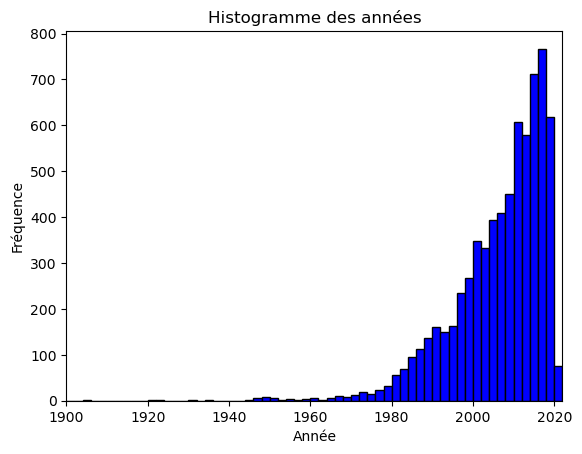

In [13]:

#On fait un histogramme de la création des festivals par année 

plt.hist(col_None, bins=np.arange(1900, max(col_None) + 2, 2), color='blue', edgecolor='black')
plt.xlabel('Année')
plt.ylabel('Fréquence')
plt.title('Histogramme des années')
plt.xlim(1900, max(col_None))
plt.show()

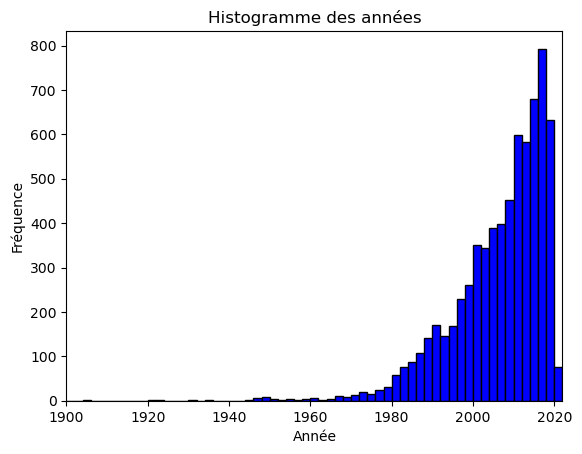

Quelle est la discipline la plus représentée ? 

In [14]:
print(df_festival['discipline_dominante'].value_counts())

discipline_dominante
Musique                          3228
Spectacle vivant                 1633
Livre, littérature                892
Cinéma, audiovisuel               685
Pluridisciplinaire                462
Arts visuels, arts numériques     382
Name: count, dtype: int64


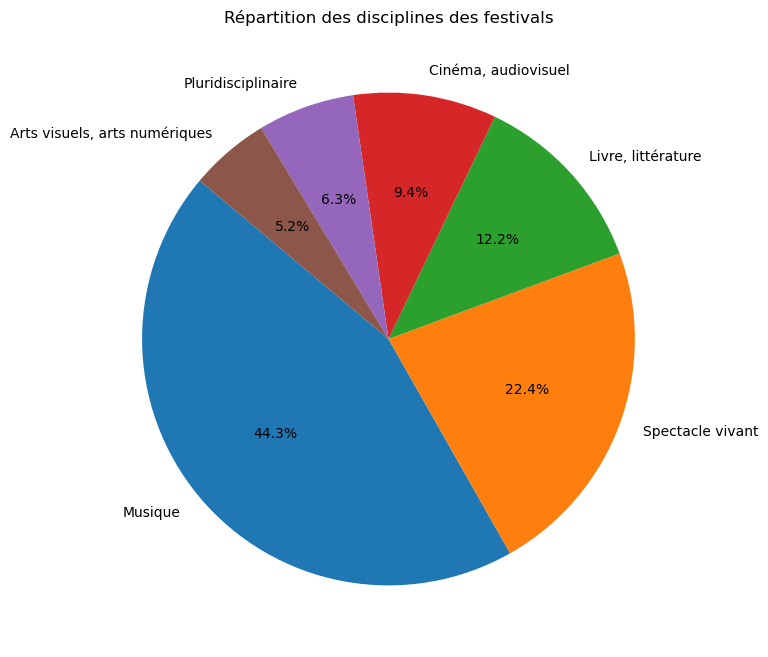

In [15]:
discipline_dom = df_festival['discipline_dominante'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(discipline_dom, labels= discipline_dom.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des disciplines des festivals')
plt.show()

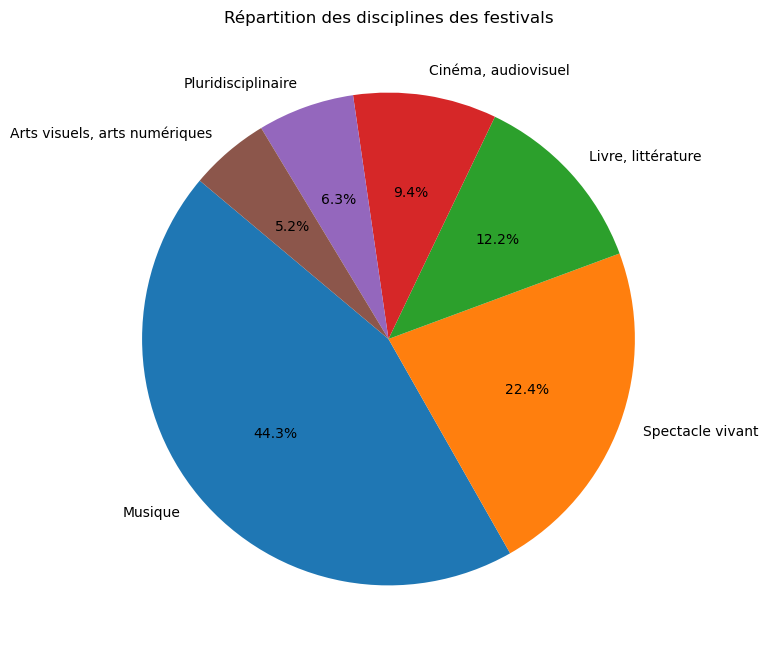

La majorité des festivals sont des festivals de musique.
Concentrons-nous sur la colonne sous catégorie de musique cnm qui donne, pour chaque de festival de musique, son "sous-style" défini selon les libéllés du Conservatoire National de Musique. 

Les catégories flous (musiques sans distinction esthétique, pluridisciplinaire) ou celles qui sont à la marge de la discipline (humour, comédie musicale...) sont placées dans autres pour clarifier la lecture des statistiques descriptives en conservant le même niveau de pertinence.

In [16]:
mapping_sous_mus = {
    '1- Chanson' : 'Chanson',
    '02- Musiques amplifiées ou électroniques' : 'Électro',
    '03- Jazz, blues et musiques improvisées' : 'Jazz, blues',
    '04- Musiques traditionnelles et du monde' : 'Musique du monde',
    '05- Humour': 'Autres',
    '07- Musiques actuelles sans distinction': 'Musiques actuelles',
    '08- Musiques (sans distinction esthétique)' : 'Sans sous catégorie',
    '09- Pluridisciplinaire': 'Pluridisciplinaire',
    '10- Comédie musicale': 'Autres',
    '11- Musique classique, lyrique, contemporaine, autres': 'Musique classique',
    '13- Autres spectacles (théâtre, arts de la rue et du cirque...)': 'Autres',
    '14- Autres disciplines culturelles (arts plastiques, cinéma, photographie, livre...)': 'Autres',
    '15- Fête de la ville, feria, fête votive, fête de la pomme, etc.': 'Fêtes de villes ou villages'
}


Nombre de valeurs non-NaN dans 'sous_categorie_musique_cnm': 958


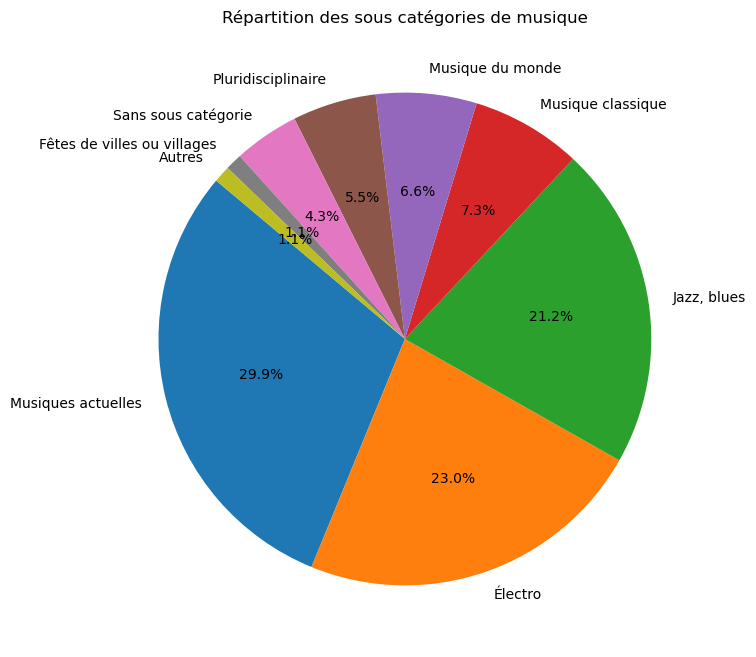

In [17]:
musique_dom = df_festival['sous_categorie_musique_cnm'].map(mapping_sous_mus).value_counts()

nombre_non_nan = df_festival['sous_categorie_musique_cnm'].notna().sum()
print(f"Nombre de valeurs non-NaN dans 'sous_categorie_musique_cnm': {nombre_non_nan}")


plt.figure(figsize=(8,8))
plt.pie(musique_dom, labels= musique_dom.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des sous catégories de musique')
plt.show()

On cherche à comparer la tranche d'âge majoritaire dans les communes accueillant un festival de musique classique et celle dans les communes accueillant un festival de musique électro. 

In [18]:
festivals_musique_classique = df_merged[df_merged['sous_categorie_musique_cnm'] == '11- Musique classique, lyrique, contemporaine, autres']
festivals_electro = df_merged[df_merged['sous_categorie_musique_cnm'] == '02- Musiques amplifiées ou électroniques']


print(df_merged['tranche_age_majoritaire'].value_counts())
print(festivals_musique_classique['tranche_age_majoritaire'].value_counts())
print(festivals_electro['tranche_age_majoritaire'].value_counts())

tranche_age_majoritaire
3 - Pop 45-59 ans en 2019 (princ)    1234
4 - Pop 60-74 ans en 2019 (princ)     943
1 - Pop 15-29 ans en 2019 (princ)     936
0 - Pop 0-14 ans en 2019 (princ)      207
2 - Pop 30-44 ans en 2019 (princ)     205
5 - Pop 75-89 ans en 2019 (princ)       6
Name: count, dtype: int64
tranche_age_majoritaire
4 - Pop 60-74 ans en 2019 (princ)    14
1 - Pop 15-29 ans en 2019 (princ)    12
3 - Pop 45-59 ans en 2019 (princ)     8
2 - Pop 30-44 ans en 2019 (princ)     1
0 - Pop 0-14 ans en 2019 (princ)      1
Name: count, dtype: int64
tranche_age_majoritaire
1 - Pop 15-29 ans en 2019 (princ)    32
3 - Pop 45-59 ans en 2019 (princ)    28
4 - Pop 60-74 ans en 2019 (princ)    22
0 - Pop 0-14 ans en 2019 (princ)      7
2 - Pop 30-44 ans en 2019 (princ)     3
5 - Pop 75-89 ans en 2019 (princ)     1
Name: count, dtype: int64


On voit que la tranche d'âge majoritraire dans la plupart des communes est la tranche d'âge 45-59 ans. Tandis que les festivals de musique classique sont dans des communes où en moyenne, la tranche d'âge majoritaire est plus âgée (60-74 ans). Et 15-29 ans pour les communes dans lesquelles il y a de la musique électro. 

Mais pas très fort car en effectif, cela se joue à 2-4 communes...

De la même manière, on regarde en fonctions des PCS

In [20]:
print(df_merged['PCS_maj'].value_counts())
print(festivals_musique_classique['PCS_maj'].value_counts())
print(festivals_electro['PCS_maj'].value_counts())

PCS_maj
3 - Employés                2140
4 - Prof. Intermédiaires     507
2 - Ouvriers                 460
5 - Cadres                   390
1 - ACCE (Artisans...)        20
0 - Agriculteurs              14
Name: count, dtype: int64
PCS_maj
3 - Employés                23
5 - Cadres                   5
2 - Ouvriers                 5
4 - Prof. Intermédiaires     3
Name: count, dtype: int64
PCS_maj
3 - Employés                50
2 - Ouvriers                18
4 - Prof. Intermédiaires    15
5 - Cadres                  10
Name: count, dtype: int64


Nous obtenons des résultats à prendre avec beaucop de modération puisque les effectifs sont grandement réduit lorsque l'on considère qu'un seul type de musique et sont trop petits pour tirer de vraies conclusions. 

D'ailleurs on a un rapport d'environ 1/5 entre le nombre de communes dominées par des cadres et par des employés dans les trois cas. **Le résultat le plus intéressant est sans doute que, dans le cas des festivals de musique électroniques on a un rapport de 1/3 entre les communes à dominante ouvrières et celles à dominante employé** tandis qu'on a aussi 1/5 dans le cas des festivals de musique classique et en général. 

In [157]:
print(df_merged['region_principale_de_deroulement'].value_counts())

Auvergne-Rhône-Alpes          947
Provence-Alpes-Côte d'Azur    942
Occitanie                     903
Nouvelle-Aquitaine            828
Île-de-France                 654
Bretagne                      590
Grand Est                     468
Bourgogne-Franche-Comté       442
Centre-Val de Loire           357
Hauts-de-France               338
Pays de la Loire              332
Normandie                     267
Corse                          69
Guadeloupe                     44
La Réunion                     41
Guyane                         19
Martinique                     15
Mayotte                         9
Polynésie française             7
Nouvelle-Calédonie              5
Saint-Barthélemy                3
Saint-Pierre-et-Miquelon        2
Name: region_principale_de_deroulement, dtype: int64


## III. Modelisation
### A) Carte !!!



### B) Regressions logistiques multinomiales : on tente d'estimer la discipline dominante du festival en fonction de 1) âge moyen de la commune 2) la PCS "moyenne" de la commune

In [245]:
# I. Première reg

# Exclure les lignes avec des valeurs manquantes dans 'tranche_age_majoritaire'
data_filtered = df_merged.dropna(subset=['numerotation_tranche'])

data_filtered['numerotation_tranche'] = data_filtered['numerotation_tranche'].astype('int64')
data_filtered['discipline_dominante'].head()

# Convertir en type catégoriel
cat_discipline_dominante = pd.Categorical(data_filtered['discipline_dominante'])

# Obtenir le mappage entre catégories et codes
mapping = dict(enumerate(cat_discipline_dominante.categories))
print(mapping)


data_filtered['discipline_dominante'] = pd.Categorical(data_filtered['discipline_dominante']).codes


data_filtered['discipline_dominante'].head()

# Préparation des variables explicatives (caractéristiques) et de la variable cible
X_filtered = data_filtered[['numerotation_tranche']]
y_filtered = data_filtered['discipline_dominante']

# Créez le modèle de régression logistique multinomiale
model_filtered = smf.mnlogit(f'discipline_dominante ~ numerotation_tranche', data=data_filtered)  # Ajoutez une constante (intercept) aux données

# Ajustez le modèle aux données
results_filtered = model_filtered.fit()

# Obtenez un tableau récapitulatif des résultats
summary_filtered = results_filtered.summary()
print(summary_filtered)

# Pour savoir ce qu'il se passe 
cat_mapping = dict(enumerate(pd.Categorical(data_filtered['discipline_dominante']).categories))
print(cat_mapping)
"""
mapping_typefest = {
    0: 'Arts visuels, arts numériques'
    1: 'Cinéma, audiovisuel'
    2: 'Livre, littérature'
    3: 'Musique'
    4: 'Pluridisciplinaire'
    5: 'Spectacle vivant'
}
"""

/var/folders/qw/b1h94pqd2pq3qzj8rr8wl1dw0000gn/T/ipykernel_30759/985049646.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['numerotation_tranche'] = data_filtered['numerotation_tranche'].astype('int64')
/var/folders/qw/b1h94pqd2pq3qzj8rr8wl1dw0000gn/T/ipykernel_30759/985049646.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['discipline_dominante'] = pd.Categorical(data_filtered['discipline_dominante']).codes


{0: 'Arts visuels, arts numériques', 1: 'Cinéma, audiovisuel', 2: 'Livre, littérature', 3: 'Musique', 4: 'Pluridisciplinaire', 5: 'Spectacle vivant'}
Optimization terminated successfully.
         Current function value: 1.484205
         Iterations 6
                           MNLogit Regression Results                           
Dep. Variable:     discipline_dominante   No. Observations:                 3531
Model:                          MNLogit   Df Residuals:                     3521
Method:                             MLE   Df Model:                            5
Date:                  Thu, 28 Dec 2023   Pseudo R-squ.:                0.006149
Time:                          13:33:38   Log-Likelihood:                -5240.7
converged:                         True   LL-Null:                       -5273.2
Covariance Type:              nonrobust   LLR p-value:                 1.205e-12
discipline_dominante=1       coef    std err          z      P>|z|      [0.025      0.975]
---------

In [28]:
# II. Régression 2 
# Exclure les lignes avec des valeurs manquantes dans 'numerotation_tranche'
data_filtered = df_merged.dropna(subset=['numerotation_tranche'])

# Filtrer pour les données où 'discipline_dominante' est 'Musique'
data_filtered_mus = data_filtered[data_filtered['discipline_dominante'] == 'Musique']
data_filtered_mus['numerotation_tranche'] = data_filtered_mus['numerotation_tranche'].astype('int64')

# Convertir 'sous_categorie_musique_cnm' en catégorie et conserver les catégories originales pour le mapping
temp_cat = pd.Categorical(data_filtered_mus['sous_categorie_musique_cnm'])
cat_mapping = dict(enumerate(temp_cat.categories))
print("Mapping des catégories originales :", cat_mapping)

# Convertir les catégories en codes pour le modèle
data_filtered_mus['sous_categorie_musique_cnm'] = temp_cat.codes

# Préparation des variables explicatives (caractéristiques) et de la variable cible
X_filtered = data_filtered_mus[['numerotation_tranche']]
y_filtered = data_filtered_mus['sous_categorie_musique_cnm']

# Créer le modèle de régression logistique multinomiale
model_filtered_mus = smf.mnlogit('sous_categorie_musique_cnm ~ numerotation_tranche', data=data_filtered_mus)

# Ajuster le modèle aux données
results_filtered_mus = model_filtered_mus.fit()

# Obtenir un tableau récapitulatif des résultats
summary_filtered_mus = results_filtered_mus.summary()
print(summary_filtered_mus)


/var/folders/qw/b1h94pqd2pq3qzj8rr8wl1dw0000gn/T/ipykernel_65680/28760195.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered_mus['numerotation_tranche'] = data_filtered_mus['numerotation_tranche'].astype('int64')
/var/folders/qw/b1h94pqd2pq3qzj8rr8wl1dw0000gn/T/ipykernel_65680/28760195.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered_mus['sous_categorie_musique_cnm'] = temp_cat.codes


Mapping des catégories originales : {0: '01- Chanson', 1: '02- Musiques amplifiées ou électroniques', 2: '03- Jazz, blues et musiques improvisées', 3: '04- Musiques traditionnelles et du monde', 4: '05- Humour', 5: '07- Musiques actuelles sans distinction', 6: '08- Musiques (sans distinction esthétique)', 7: '09- Pluridisciplinaire', 8: '11- Musique classique, lyrique, contemporaine, autres', 9: '13- Autres spectacles (théâtre, arts de la rue et du cirque...)', 10: '14- Autres disciplines culturelles (arts plastiques, cinéma, photographie, livre...)', 11: '15- Fête de la ville, feria, fête votive, fête de la pomme, etc.'}


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3027: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3028: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]


Optimization terminated successfully.
         Current function value: nan
         Iterations 4
                              MNLogit Regression Results                              
Dep. Variable:     sous_categorie_musique_cnm   No. Observations:                 1581
Model:                                MNLogit   Df Residuals:                     1557
Method:                                   MLE   Df Model:                           12
Date:                        Fri, 29 Dec 2023   Pseudo R-squ.:                     nan
Time:                                14:37:16   Log-Likelihood:                    nan
converged:                               True   LL-Null:                       -1827.3
Covariance Type:                    nonrobust   LLR p-value:                       nan
 sous_categorie_musique_cnm=0       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept  

In [185]:
# III. Reg 3 : revenu et discipline dominante

# I. Première reg

# Exclure les lignes avec des valeurs manquantes dans 'tranche_age_majoritaire'
data_filtered2 = df_merged.dropna(subset=['numerotation_PCS'])

data_filtered2['numerotation_PCS'] = data_filtered2['numerotation_PCS'].astype('int64')
print(data_filtered2['discipline_dominante'])

data_filtered2['discipline_dominante'] = pd.Categorical(data_filtered2['discipline_dominante']).codes

#print(data_filtered2['discipline_dominante'])

# Préparation des variables explicatives (caractéristiques) et de la variable cible
X_filtered = data_filtered2[['numerotation_PCS']]
y_filtered = data_filtered2['discipline_dominante']

# Créez le modèle de régression logistique multinomiale
model_filtered2 = smf.mnlogit(f'discipline_dominante ~ numerotation_PCS', data=data_filtered2)  # Ajoutez une constante (intercept) aux données

# Ajustez le modèle aux données
results_filtered2 = model_filtered2.fit()

# Obtenez un tableau récapitulatif des résultats
summary_filtered2 = results_filtered2.summary()
print(summary_filtered2)

# Pour savoir ce qu'il se passe 
cat_mapping = dict(enumerate(pd.Categorical(data_filtered2['discipline_dominante']).categories))
print(cat_mapping)


/var/folders/qw/b1h94pqd2pq3qzj8rr8wl1dw0000gn/T/ipykernel_30759/178928703.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered2['numerotation_PCS'] = data_filtered2['numerotation_PCS'].astype('int64')
/var/folders/qw/b1h94pqd2pq3qzj8rr8wl1dw0000gn/T/ipykernel_30759/178928703.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered2['discipline_dominante'] = pd.Categorical(data_filtered2['discipline_dominante']).codes


0                 Cinéma, audiovisuel
2                 Cinéma, audiovisuel
3                  Livre, littérature
4                    Spectacle vivant
5                    Spectacle vivant
11                   Spectacle vivant
12      Arts visuels, arts numériques
19                   Spectacle vivant
20                 Pluridisciplinaire
21                            Musique
24                            Musique
26                            Musique
27                   Spectacle vivant
29                            Musique
30                            Musique
31                            Musique
32                   Spectacle vivant
34                            Musique
36                 Livre, littérature
38                 Pluridisciplinaire
39                 Livre, littérature
40                Cinéma, audiovisuel
42                   Spectacle vivant
46                   Spectacle vivant
48                 Livre, littérature
50                            Musique
54          

Aucune valeur vrmt significative mais bon on aura tenté 